In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
a = torch.arange(2*3*1*1)
print(a.shape,a)

torch.Size([6]) tensor([0, 1, 2, 3, 4, 5])


In [4]:
torch.reshape(a, (2,3,1,1))

tensor([[[[0]],

         [[1]],

         [[2]]],


        [[[3]],

         [[4]],

         [[5]]]])

In [5]:
torch.reshape(a, (2*3,1,1))

tensor([[[0]],

        [[1]],

        [[2]],

        [[3]],

        [[4]],

        [[5]]])

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [8]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [9]:
# print(foreground_data.size())
# print(background_data.size())
# torch.save(foreground_data,'foreground_data.pt')
# torch.save(background_data,'background_data.pt')
# torch.save(foreground_label,'foreground_label.pt')
# torch.save(background_label,'background_label.pt')
# torch.load()

In [10]:
# torch.load('foreground_data.pt')
# # print(foreground_data.size())
# # print(background_data.size())

In [11]:

# foreground_data = torch.load('foreground_data.pt')
# background_data = torch.load('background_data.pt')
# foreground_label = torch.load('foreground_label.pt')
# background_label = torch.load('background_label.pt')


In [12]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [13]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



In [14]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Conv_module(nn.Module):
    def __init__(self,inp_ch,f,s,k,pad):
        super(Conv_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.s = s 
        self.k = k 
        self.pad = pad
        
        
        self.conv = nn.Conv2d(self.inp_ch,self.f,k,stride=s,padding=self.pad)
        self.bn = nn.BatchNorm2d(self.f)
        self.act = nn.ReLU()
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [16]:
class inception_module(nn.Module):
    def __init__(self,inp_ch,f0,f1):
        super(inception_module, self).__init__()
        self.inp_ch = inp_ch
        self.f0 = f0
        self.f1 = f1        
        self.conv1 = Conv_module(self.inp_ch,self.f0,1,1,pad=0)
        self.conv3 = Conv_module(self.inp_ch,self.f1,1,3,pad=1)
        #self.conv1 = nn.Conv2d(3,self.f0,1)
        #self.conv3 = nn.Conv2d(3,self.f1,3,padding=1)
    def forward(self,x):
        x1 = self.conv1.forward(x)
        x3 = self.conv3.forward(x)
        #print(x1.shape,x3.shape)
        x = torch.cat((x1,x3),dim=1)   
        return x

In [17]:
class downsample_module(nn.Module):
    def __init__(self,inp_ch,f):
        super(downsample_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.conv = Conv_module(self.inp_ch,self.f,2,3,pad=0)
        self.pool = nn.MaxPool2d(3,stride=2,padding=0)
    def forward(self,x):
        x1 = self.conv(x)
        #print(x1.shape)
        x2 = self.pool(x)
        #print(x2.shape)
        x = torch.cat((x1,x2),dim=1)
        
        return x,x1

In [18]:
class inception_net(nn.Module):
    def __init__(self):
        super(inception_net,self).__init__()
        self.conv1 = Conv_module(3*9,96,1,3,0)
        
        self.incept1 = inception_module(96,32,32)
        self.incept2 = inception_module(64,32,48)
        
        self.downsample1 = downsample_module(80,80)
        
        self.incept3 = inception_module(160,112,48)
        self.incept4 = inception_module(160,96,64)
        self.incept5 = inception_module(160,80,80)
        self.incept6 = inception_module(160,48,96)
        
        self.downsample2 = downsample_module(144,96)
        
        self.incept7 = inception_module(240,176,60)
        self.incept8 = inception_module(236,176,60)
        
        self.pool = nn.AvgPool2d(5)
        self.linear1 = nn.Linear(236,10)
        self.linear2 = nn.Linear(10,3)

    def forward(self,x):
        x = self.conv1.forward(x)
        #act1 = x
        
        x = self.incept1.forward(x)
        #act2 = x
        
        x = self.incept2.forward(x)
        #act3 = x
        
        x,act4 = self.downsample1.forward(x)
        
        x = self.incept3.forward(x)
        #act5 = x
        
        x = self.incept4.forward(x)
        #act6 = x
        
        x = self.incept5.forward(x)
        #act7 = x
        
        x = self.incept6.forward(x)
        #act8 = x
        
        x,act9 = self.downsample2.forward(x)
        
        x = self.incept7.forward(x)
        #act10 = x
        x = self.incept8.forward(x)
        #act11 = x
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1,1*1*236)
        x = self.linear1(x)
        x = self.linear2(x) 
        # print(x.shape)
        return x

In [19]:
block_net = inception_net()
block_net = block_net.to("cuda").double()

In [20]:
block_net

inception_net(
  (conv1): Conv_module(
    (conv): Conv2d(27, 96, kernel_size=(3, 3), stride=(1, 1))
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (incept1): inception_module(
    (conv1): Conv_module(
      (conv): Conv2d(96, 32, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv3): Conv_module(
      (conv): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
  )
  (incept2): inception_module(
    (conv1): Conv_module(
      (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (conv3): Conv_module(
      (conv): Conv2d(64, 48, kernel_size=(3, 3), stride

In [21]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [22]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [23]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(block_net.parameters(), lr=0.001, momentum=0.9)

In [24]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    block_net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, data in enumerate(train_loader):
        inputs , labels , fore_idx = data
        inputs = inputs.double()
        # zero the parameter gradients
        # print(inputs.shape)
        inputs = torch.reshape(inputs,(batch,9*3,32,32))
        # print(inputs.shape)
        inputs , labels , fore_idx = inputs.to("cuda") , labels.to("cuda"), fore_idx.to("cuda")
        optimizer.zero_grad()
        outputs = block_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return train_loss/(batch_idx+1)



In [25]:
# Commented out IPython magic to ensure Python compatibility.
def test(epoch):
    global best_acc
    block_net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            inputs , labels , fore_idx = data
            inputs = inputs.double()
            # zero the parameter gradients
            # print(inputs.shape)
            inputs = torch.reshape(inputs,(batch,9*3,32,32))
            # print(inputs.shape)
            inputs , labels , fore_idx = inputs.to("cuda") , labels.to("cuda"), fore_idx.to("cuda")
            outputs = block_net(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    return test_loss/(batch_idx+1)



In [26]:
best_acc = 0 
start_epoch =0
tr_loss = []
ts_loss = []
for epoch in range(start_epoch, start_epoch+150):
    tr_loss.append(train(epoch))
    ts_loss.append(test(epoch))
    if(tr_loss[-1]<=0.001):
      break



Epoch: 0
119 5000 Loss: 1.100 | Acc: 36.140% (10842/30000)
39 1000 Loss: 1.090 | Acc: 37.910% (3791/10000)

Epoch: 1
119 5000 Loss: 1.081 | Acc: 40.563% (12169/30000)
39 1000 Loss: 1.083 | Acc: 38.840% (3884/10000)

Epoch: 2
119 5000 Loss: 1.069 | Acc: 42.613% (12784/30000)
39 1000 Loss: 1.078 | Acc: 40.410% (4041/10000)

Epoch: 3
119 5000 Loss: 1.058 | Acc: 44.407% (13322/30000)
39 1000 Loss: 1.073 | Acc: 41.290% (4129/10000)

Epoch: 4
119 5000 Loss: 1.046 | Acc: 46.047% (13814/30000)
39 1000 Loss: 1.074 | Acc: 41.300% (4130/10000)

Epoch: 5
119 5000 Loss: 1.032 | Acc: 47.287% (14186/30000)
39 1000 Loss: 1.067 | Acc: 42.630% (4263/10000)

Epoch: 6
119 5000 Loss: 1.016 | Acc: 48.987% (14696/30000)
39 1000 Loss: 1.071 | Acc: 42.480% (4248/10000)

Epoch: 7
119 5000 Loss: 0.995 | Acc: 51.223% (15367/30000)
39 1000 Loss: 1.080 | Acc: 41.590% (4159/10000)

Epoch: 8
119 5000 Loss: 0.967 | Acc: 53.697% (16109/30000)
39 1000 Loss: 1.092 | Acc: 42.170% (4217/10000)

Epoch: 9
119 5000 Loss: 0.9

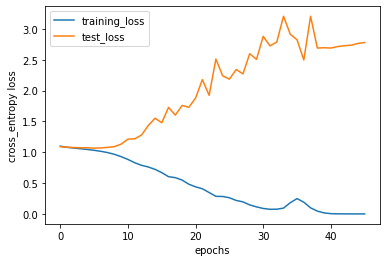

In [27]:
plt.plot(tr_loss,label='training_loss')
plt.plot(ts_loss,label = 'test_loss')
plt.xlabel("epochs")
plt.ylabel("cross_entropy loss")
plt.legend()

In [28]:
torch.save(block_net.state_dict(),"/content/drive/My Drive/Research/block_net/block_net_mini_inception_epoch"+str(epoch)+".pt")

In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        inputs , labels , fore_idx = data
        inputs = torch.reshape(inputs,(batch,9*3,32,32))
        inputs , labels , fore_idx = inputs.to("cuda") , labels.to("cuda"), fore_idx.to("cuda")
        outputs = block_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d train images: %d %%' % (total,  100 * correct / total))
print(total,correct)

Accuracy of the network on the 30000 train images: 100 %
30000 30000


In [30]:
correct = 0
total = 0
out = []
pred = []
with torch.no_grad():
    for data in test_loader:
        inputs , labels , fore_idx = data
        inputs = torch.reshape(inputs,(batch,9*3,32,32))
        inputs , labels , fore_idx = inputs.to("cuda") , labels.to("cuda"), fore_idx.to("cuda")
        outputs = block_net(inputs)
        out.append(labels.cpu().numpy())
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print(total,correct)

Accuracy of the network on the 10000 test images: 39 %
10000 3993
